In [15]:
pip install tensorflow



  Using cached absl_py-2.1.0-py3-none-any.whl.metadata (2.3 kB)
     ---------------------------------------- 0.0/48.6 kB ? eta -:--:--
     ---------------------------------------- 48.6/48.6 kB 1.2 MB/s eta 0:00:00
   ---------------------------------------- 0.0/390.3 MB ? eta -:--:--
   ---------------------------------------- 0.1/390.3 MB 3.6 MB/s eta 0:01:48
   ---------------------------------------- 0.2/390.3 MB 2.9 MB/s eta 0:02:16
   ---------------------------------------- 0.5/390.3 MB 3.5 MB/s eta 0:01:51
   ---------------------------------------- 0.6/390.3 MB 3.3 MB/s eta 0:01:57
   ---------------------------------------- 0.7/390.3 MB 3.6 MB/s eta 0:01:48
   ---------------------------------------- 1.0/390.3 MB 3.6 MB/s eta 0:01:48
   ---------------------------------------- 1.2/390.3 MB 3.7 MB/s eta 0:01:44
   ---------------------------------------- 1.4/390.3 MB 3.9 MB/s eta 0:01:39
   ---------------------------------------- 1.6/390.3 MB 3.9 MB/s eta 0:01:40
   -------

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [16]:
# Import libraries
import tensorflow as tf
from tensorflow.keras import layers, Model, Input
import numpy as np
import matplotlib.pyplot as plt

In [17]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0  # Normalize

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [18]:
def create_pairs(x, y):
    pairs, labels = [], []
    num_classes = len(np.unique(y))
    digit_indices = [np.where(y == i)[0] for i in range(num_classes)]
    
    for idx1 in range(len(x)):
        x1, label1 = x[idx1], y[idx1]
        # Positive pair (same class)
        idx2 = np.random.choice(digit_indices[label1])
        x2 = x[idx2]
        pairs.append([x1, x2])
        labels.append(1)
        
        # Negative pair (different class)
        label2 = np.random.choice(np.delete(np.arange(num_classes), label1))
        idx2 = np.random.choice(digit_indices[label2])
        x2 = x[idx2]
        pairs.append([x1, x2])
        labels.append(0)
    
    return np.array(pairs), np.array(labels)

pairs_train, labels_train = create_pairs(x_train, y_train)
pairs_test, labels_test = create_pairs(x_test, y_test)

# Prepare input for the Siamese Network
def preprocess_pairs(pairs):
    pair1 = pairs[:, 0].reshape(-1, 28, 28, 1)
    pair2 = pairs[:, 1].reshape(-1, 28, 28, 1)
    return [pair1, pair2]

train_pair1, train_pair2 = preprocess_pairs(pairs_train)
test_pair1, test_pair2 = preprocess_pairs(pairs_test)


In [19]:
# Define the Siamese Network architecture
def create_siamese_network(input_shape):
    # Base Network for Feature Extraction
    base_input = Input(shape=input_shape)
    x = layers.Conv2D(64, (3, 3), activation='relu')(base_input)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)
    feature_extractor = Model(base_input, x)

    # Input layers for the Siamese Network
    input1 = Input(shape=input_shape)
    input2 = Input(shape=input_shape)

    # Generate embeddings
    embedding1 = feature_extractor(input1)
    embedding2 = feature_extractor(input2)

    # Compute the L2 distance between embeddings
    l2_distance = layers.Lambda(lambda tensors: tf.math.abs(tensors[0] - tensors[1]))([embedding1, embedding2])
    output = layers.Dense(1, activation='sigmoid')(l2_distance)

    siamese_model = Model(inputs=[input1, input2], outputs=output)
    return siamese_model




In [20]:
# Initialize the Siamese Network
input_shape = (28, 28, 1)
siamese_model = create_siamese_network(input_shape)

# Compile the model
siamese_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [21]:
# Train the Siamese Network
history = siamese_model.fit(
    [train_pair1, train_pair2], labels_train,
    validation_data=([test_pair1, test_pair2], labels_test),
    batch_size=32,
    epochs=5
)

Epoch 1/5
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 284s 73ms/step - accuracy: 0.8677 - loss: 0.3094 - val_accuracy: 0.9107 - val_loss: 0.2150
Epoch 2/5
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 262s 70ms/step - accuracy: 0.9296 - loss: 0.1748 - val_accuracy: 0.9219 - val_loss: 0.1959
Epoch 3/5
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 378s 101ms/step - accuracy: 0.9479 - loss: 0.1317 - val_accuracy: 0.9196 - val_loss: 0.2010
Epoch 4/5
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 249s 66ms/step - accuracy: 0.9600 - loss: 0.1024 - val_accuracy: 0.9262 - val_loss: 0.1964
Epoch 5/5
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 183s 49ms/step - accuracy: 0.9693 - loss: 0.0793 - val_accuracy: 0.9207 - val_loss: 0.2219


In [22]:
loss, accuracy = siamese_model.evaluate([test_pair1, test_pair2], labels_test)
print(f"Test Accuracy: {accuracy:.2f}")

625/625 ━━━━━━━━━━━━━━━━━━━━ 15s 23ms/step - accuracy: 0.9191 - loss: 0.2269
Test Accuracy: 0.92


In [23]:

# Generate embeddings for similarity search
feature_extractor = siamese_model.layers[2]  # Extract the base feature extractor
test_embeddings = feature_extractor.predict(x_test.reshape(-1, 28, 28, 1))

313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step


In [24]:
# Perform similarity search (e.g., using cosine similarity)
from sklearn.metrics.pairwise import cosine_similarity

query_image = x_test[0].reshape(1, 28, 28, 1)
query_embedding = feature_extractor.predict(query_image)

similarities = cosine_similarity(query_embedding, test_embeddings)
most_similar_idx = np.argsort(similarities[0])[-5:]  # Top 5 similar images

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


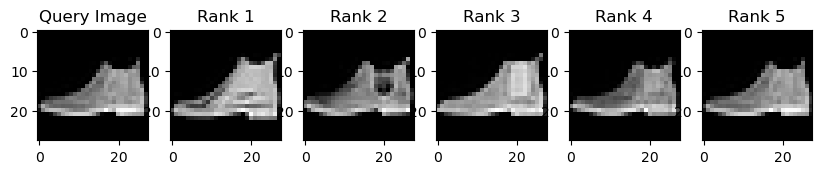

In [25]:
# Display results
plt.figure(figsize=(10, 5))
plt.subplot(1, 6, 1)
plt.imshow(query_image[0], cmap='gray')
plt.title("Query Image")

for i, idx in enumerate(most_similar_idx):
    plt.subplot(1, 6, i+2)
    plt.imshow(x_test[idx], cmap='gray')
    plt.title(f"Rank {i+1}")
plt.show()